In [10]:
import numpy as np
print(np.__version__)

import scipy as sp
print(sp.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

1.10.0.dev0+9dba7a4
0.16.0.dev0+bcf5fcd


## Counting grains and bubbles

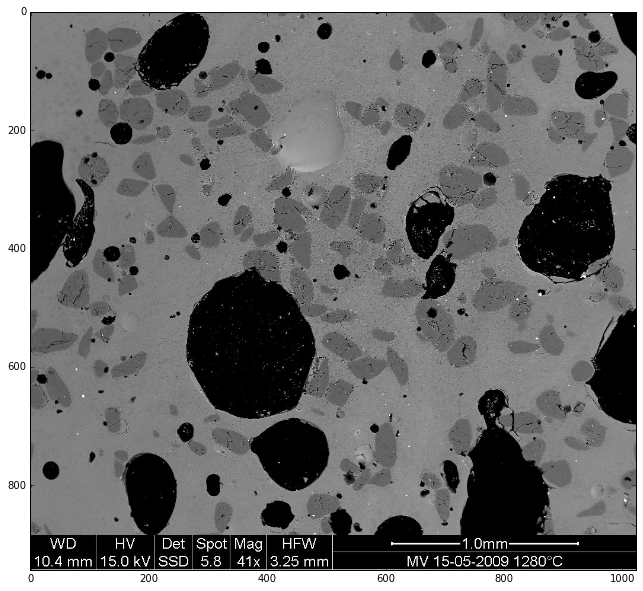

In [11]:
scan = plt.imread('bubbles.jpg')
plt.imshow(scan, cmap=plt.cm.gray)

<div class="exercise">

**Exercise**
    
1. Open the image ``bubbles.jpg`` and display it.

2. This Scanning Element Microscopy image shows a glass sample
   (light gray matrix) with some bubbles (black) and unmolten
   sand grains (dark gray). We wish to determine the fraction
   of the sample covered by these three phases,
   and to estimate the number of sand grains and bubbles,
   their average sizes, etc.

3. Crop the image to remove the lower panel with measure information.

4. Filter the image with a median filter to clean up some noise
   and to make the regions more smooth.

5. Using the histogram of the filtered image, determine thresholds
   that allow to define masks for sand pixels, glass pixels
   and bubble pixels.

6. Display an image in which the three phases are colored with
   three different colors.

   Use morphological operators to clean the different phases.

7. Attribute labels to all bubbles and sand grains, and remove
   from the sand mask grains that are smaller than 10 pixels.
   To do so, use ``ndimage.sum`` or ``np.bincount`` to compute
   the grain sizes.

8. Compute the mean size of bubbles.

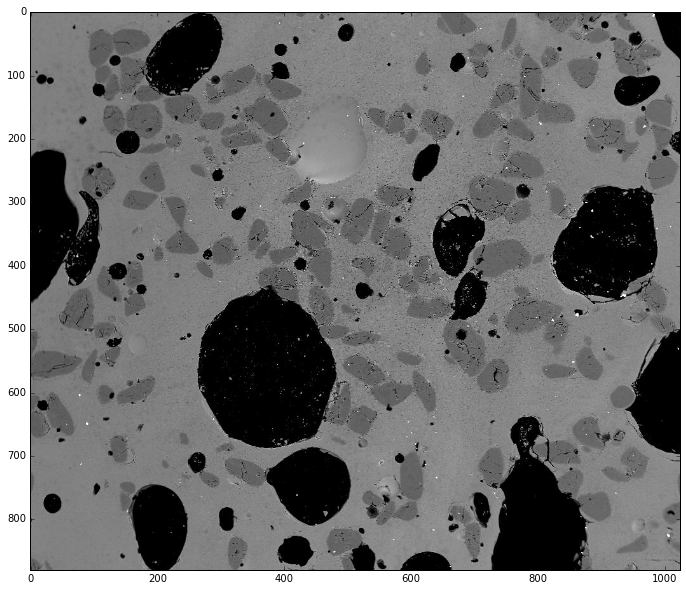

In [12]:
scan_clean = scan[:880, :]
plt.imshow(scan_clean, cmap=plt.cm.gray)

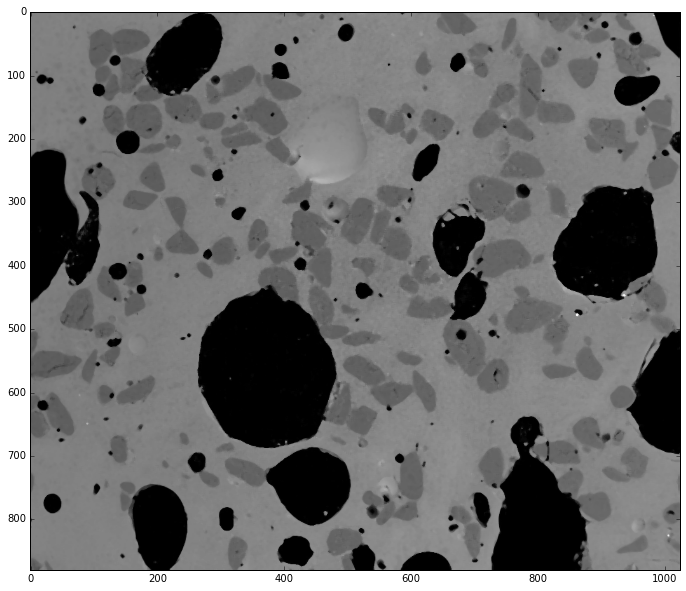

In [13]:
import scipy.ndimage as ndi
scan_med = ndi.median_filter(scan_clean, size=5)
plt.imshow(scan_med, cmap=plt.cm.gray)

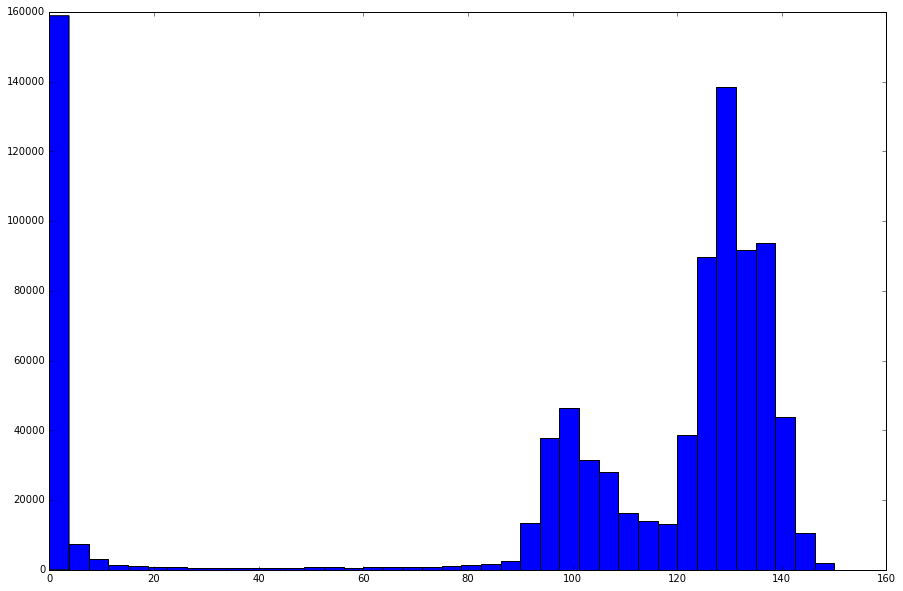

In [14]:
plt.hist(scan_med.flat, bins=40, range=(0, 150));

Based on the histogram, it looks like we should threshold at
50 and 120 to separate bubbles (black), sand (dark) and glass (light).

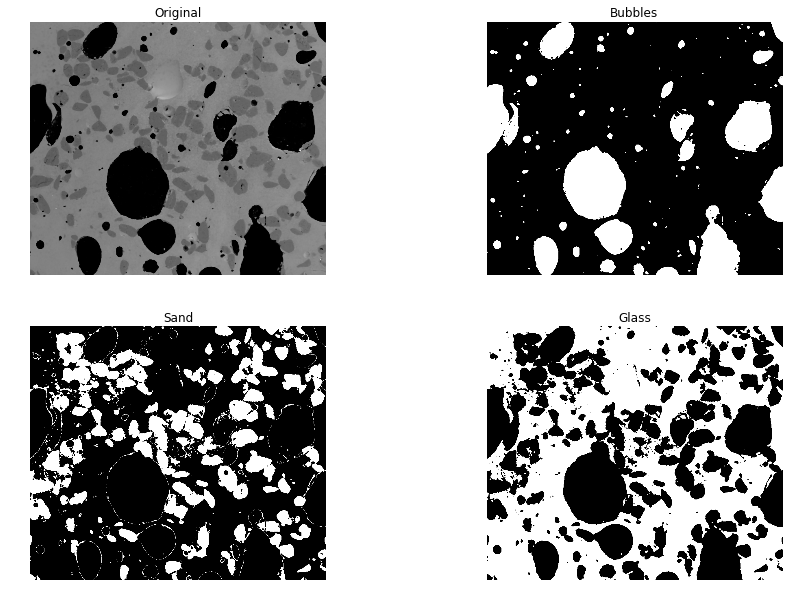

In [15]:
bubbles = (scan_med <= 50)
sand = (scan_med > 50) & (scan_med <= 120)
glass = (scan_med > 120)

def plot_images(cmap=plt.cm.gray):
    for n, (name, image) in \
        enumerate([('Original', scan_med),
                   ('Bubbles', bubbles),
                   ('Sand', sand),
                   ('Glass', glass)]):
    
        plt.subplot(2, 2, n + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(name)
        plt.axis('off')
        
plot_images()

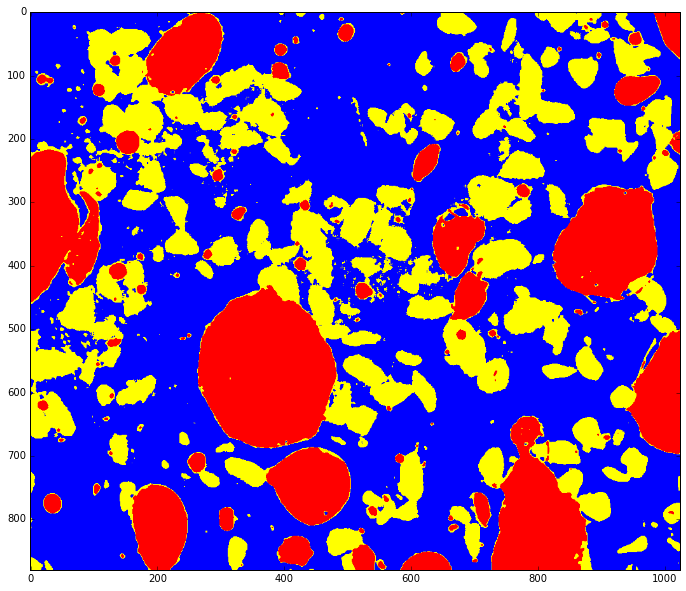

In [16]:
def plot_color_overlay():
    layers = np.zeros((scan_clean.shape[0],
                       scan_clean.shape[1], 3)) # Color image

    # You shouldn't run this if bubbles isn't a mask
    # -- otherwise, fancy indexing instead of masking
    assert(bubbles.dtype == np.bool)
    
    layers[bubbles] = (1, 0, 0)
    layers[sand] = (1, 1, 0)
    layers[glass] = (0, 0, 1)

    plt.imshow(layers)

plot_color_overlay()


### Dilation and erosion

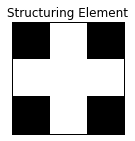

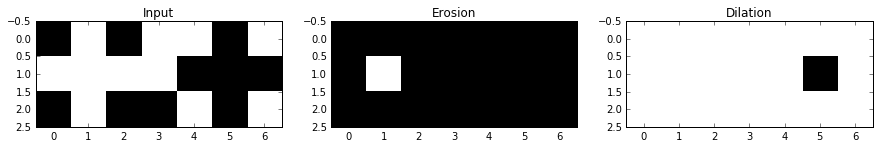

In [17]:
x = np.array([[0, 1, 0, 1, 1, 0, 1],
              [1, 1, 1, 1, 0, 0, 0],
              [0, 1, 0, 0, 1, 0, 1]])

x = x.astype(bool)


strel = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]])

plt.figure(figsize=(2, 2))
plt.imshow(strel, interpolation='nearest', cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Structuring Element')

f, (ax0, ax1, ax2) = plt.subplots(1, 3)

ax0.imshow(x, interpolation='nearest', cmap='gray')
ax0.set_title('Input')

ax1.imshow(ndi.binary_erosion(x, strel), interpolation='nearest', cmap='gray', vmin=0, vmax=1)
ax1.set_title('Erosion')

ax2.imshow(ndi.binary_dilation(x, strel), interpolation='nearest', cmap='gray', vmin=0, vmax=1);
ax2.set_title('Dilation')

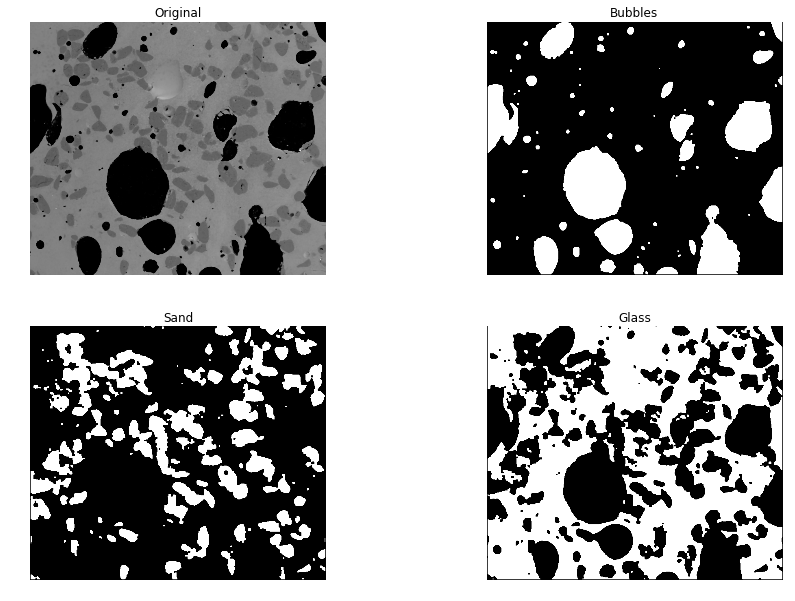

In [18]:
for img in (sand, bubbles, glass):
    # Erosion followed by dilation
    img[:] = ndi.binary_opening(img, np.ones((5, 5)))

    img[:] = ndi.binary_closing(img, np.ones((5, 5)))
    
plot_images()

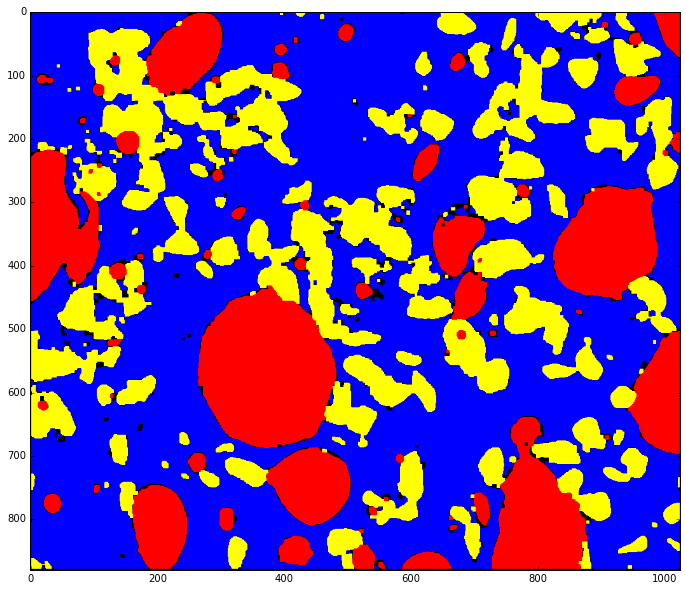

In [19]:
plot_color_overlay()

115 regions found in Sand
Mean obj area 1769
70 regions found in Bubbles
Mean obj area 2516
27 regions found in Glass
Mean obj area 19111


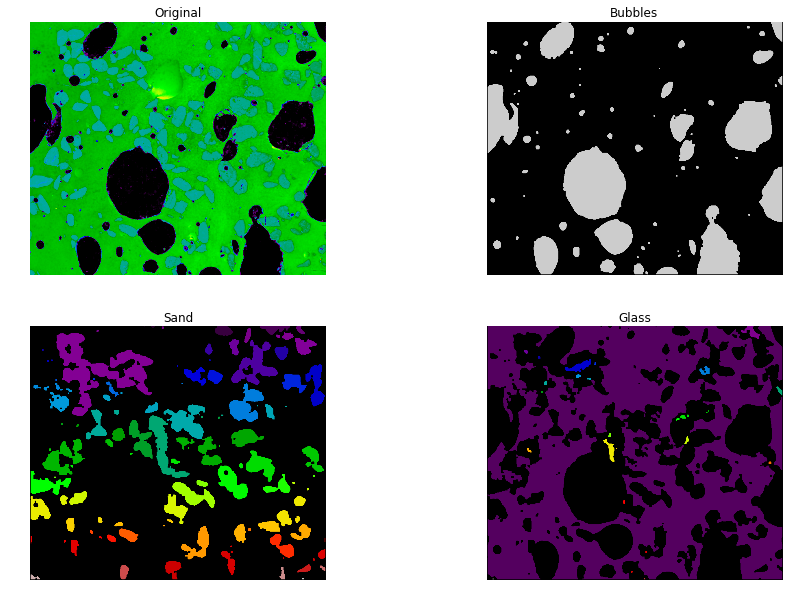

In [20]:
# Convert to int so we can store the labels
bubble = bubbles.astype(int)
sand = sand.astype(int)
glass = glass.astype(int)

for name, img in [('Sand', sand),
                  ('Bubbles', bubbles),
                  ('Glass', glass)]:
    
    labels, count = ndi.label(img)
    
    print('%s regions found in %s' % (count, name))
    img[:] = labels
    
    obj_areas = [np.sum(labels == i) for \
                 i in range(1, labels.max())]
    
    print("Mean obj area %d" % np.mean(obj_areas))

plot_images(cmap=plt.cm.spectral)